In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as st
plt.style.use('seaborn-darkgrid')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


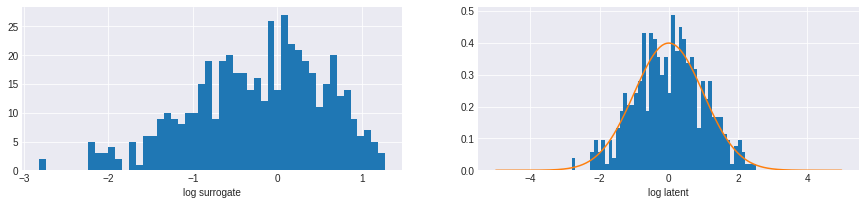

In [2]:
# generate surrogate data
sd0 = 1
mu0 = 0
ymax0 = 5
q = np.exp(np.random.randn(500)*sd0+mu0)
y = (q*ymax0)/(q + ymax0)

_, ax = plt.subplots(1, 2, figsize=(15, 3))

ax[0].hist(np.log(y), 50)
ax[0].set_xlabel('log surrogate')

ax[1].hist(np.log(q), 50, density='pdf')
x = np.linspace(-5, 5, 1000)
pdf = st.norm.pdf(x, mu0, sd0)
ax[1].plot(x, pdf)
ax[1].set_xlabel('log latent');

In [3]:
## setup model
yobsmax = np.amax(y)

with pm.Model() as ullnmodel:
    ymax = pm.Pareto('ymax', alpha=1, m=yobsmax)
#     ymax = pm.Uniform('ymax', 0, 10.)
    mu = pm.Normal('mu', mu=0, sd=5)
    sigma = pm.Lognormal('sigma', mu=0, sd=5)

    qt =  pm.math.log(y*ymax) - pm.math.log(ymax  - y)
    q2 = pm.Normal('q', mu=mu, sd = sigma, observed = qt)

startpoint = {'mu': np.mean(np.log(y)), 'sigma': np.std(np.log(y)), 'ymax': yobsmax*2.0}
map_estimate = pm.find_MAP(model=ullnmodel,start=startpoint)
map_estimate

logp = -607.13, ||grad|| = 6.4478: 100%|██████████| 16/16 [00:00<00:00, 2070.49it/s]  


{'mu': array(-0.22952959),
 'sigma': array(0.79104201),
 'sigma_log__': array(-0.2344042),
 'ymax': array(213.34445008),
 'ymax_log__': array(5.362908)}

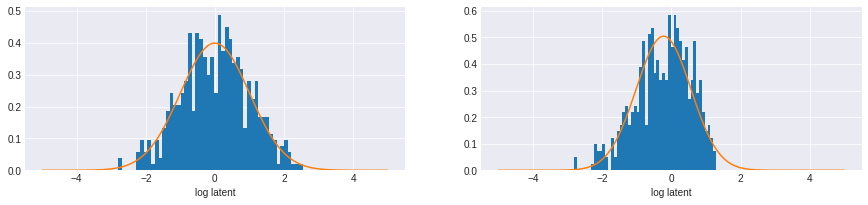

In [4]:
_, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].hist(np.log(q), 50, density='pdf')
pdf = st.norm.pdf(x, mu0, sd0)
ax[0].plot(x, pdf)
ax[0].set_xlabel('log latent')

ymax_ = map_estimate['ymax']# ymax0
qt2 = np.log(y*ymax_) - np.log(ymax_-y)
ax[1].hist(qt2, 50, density='pdf')
pdf = st.norm.pdf(x, map_estimate['mu'], map_estimate['sigma'])
ax[1].plot(x, pdf)
ax[1].set_xlabel('log latent');

In [5]:
from pymc3.distributions.transforms import ElemwiseTransform
import theano.tensor as tt
import theano


class logmax(ElemwiseTransform):

    name = "logmax"

    def __init__(self, ymax):
        self.ymax = tt.as_tensor_variable(ymax)

    def forward(self, x):
        return (x * self.ymax)/(x + self.ymax)

    def backward(self, y):
        return tt.log(y * self.ymax) - tt.log(self.ymax - y)

In [6]:
with pm.Model() as ullnmodel2:
    ymax = pm.Pareto('ymax', alpha=1, m=yobsmax)
#     ymax = pm.Uniform('ymax', 0, 10.)
    mu = pm.Normal('mu', mu=0, sd=5)
    sigma = pm.Lognormal('sigma', mu=0, sd=5)

    q2 = pm.Normal('q', mu=mu, sd = sigma, transform=logmax(ymax))

In [7]:
with ullnmodel2:
    like = pm.Potential('like', ullnmodel2.free_RVs[-1]
                                 .distribution
                                 .logp(theano.shared(y)))

In [8]:
startpoint = {'mu': np.mean(np.log(y)), 'sigma': np.std(np.log(y)), 'ymax': yobsmax*2.0}
map_estimate = pm.find_MAP(model=ullnmodel2, start=startpoint)
map_estimate

logp = nan, ||grad|| = 0: 100%|██████████| 42/42 [00:00<00:00, 2745.90it/s]  


{'mu': array(-0.23442457),
 'q': array(-inf),
 'q_logmax__': array(0.),
 'sigma': array(0.78868513),
 'sigma_log__': array(-0.23738811),
 'ymax': array(7.15733027),
 'ymax_log__': array(1.96813704)}

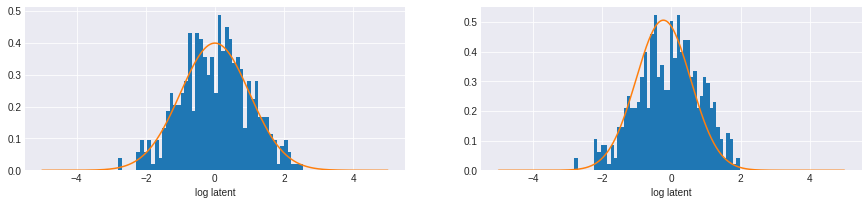

In [9]:
_, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].hist(np.log(q), 50, density='pdf')
pdf = st.norm.pdf(x, mu0, sd0)
ax[0].plot(x, pdf)
ax[0].set_xlabel('log latent')

ymax_ = map_estimate['ymax']# ymax0
qt2 = np.log(y*ymax_) - np.log(ymax_-y)
ax[1].hist(qt2, 50, density='pdf')
pdf = st.norm.pdf(x, map_estimate['mu'], map_estimate['sigma'])
ax[1].plot(x, pdf)
ax[1].set_xlabel('log latent');

$$f(y) = log(y_{max}*y/(y_{max}-y))$$
$$f(y) \sim Normal(mu,sigma)$$
$$det(log(J)) = log(df/dy) = log(y_{max}/(y*(y_{max}-y)))$$

https://discourse.pymc.io/t/how-do-i-implement-an-upper-limit-log-normal-distribution/1337/8

In [19]:
with pm.Model() as ullnmodel3:
    ymax = pm.Pareto('ymax',alpha=1,m=yobsmax)
    
    mu = pm.Normal('mu', mu=0, sd=5)
    sigma = pm.Lognormal('sigma', mu=0, sd=5)
    
    qt =  pm.math.log(y*ymax) - pm.math.log(ymax  - y)
    q2 = pm.Normal('q', mu=mu, sd = sigma, observed = qt)
    pm.Potential('jacob_det', pm.math.log(ymax/(y*(ymax-y))))
    
startpoint = {'mu': np.mean(np.log(y)), 'sigma': np.std(np.log(y)), 'ymax': 10}
map_estimate = pm.find_MAP(model=ullnmodel3,start=startpoint)
map_estimate

logp = -467.53, ||grad|| = 93.076: 100%|██████████| 20/20 [00:00<00:00, 2431.20it/s]  


{'mu': array(0.08462548),
 'sigma': array(1.04220734),
 'sigma_log__': array(0.0413409),
 'ymax': array(4.20616598),
 'ymax_log__': array(1.43655154)}

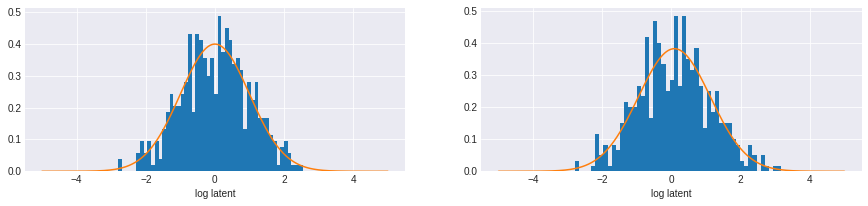

In [20]:
_, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].hist(np.log(q), 50, density='pdf')
pdf = st.norm.pdf(x, mu0, sd0)
ax[0].plot(x, pdf)
ax[0].set_xlabel('log latent')

ymax_ = map_estimate['ymax']# ymax0
qt2 = np.log(y*ymax_) - np.log(ymax_-y)
ax[1].hist(qt2, 50, density='pdf')
pdf = st.norm.pdf(x, map_estimate['mu'], map_estimate['sigma'])
ax[1].plot(x, pdf)
ax[1].set_xlabel('log latent');